In [9]:
import networkx as nx
import dimod
import dwave_networkx.algorithms.tsp as dnx

G = nx.Graph()
G.add_weighted_edges_from({(0, 1, .1), (0, 2, .5), (0, 3, .1), (1, 2, .1),
                            (1, 3, .5), (2, 3, .1)})
dnx.traveling_salesperson(G, dimod.ExactSolver(), start=3) 


[3, 0, 1, 2]

In [10]:
#!pip install pandas
#!pip install openpyxl

In [11]:
import pandas as pd

In [12]:
dat = pd.read_excel("D:\MisTrabajos\DWaveOcean\ejemplosJupyter\mios\datos1.xlsx", sheet_name='Hoja1')

In [13]:
resul = set()
for index, row in dat.iterrows():
    resul.add((row['init'],row['fin'],row['peso']))
    
resul

{(0.0, 1.0, 10.0),
 (0.0, 2.0, 0.5),
 (0.0, 3.0, 0.1),
 (1.0, 2.0, 0.1),
 (1.0, 3.0, 0.5),
 (2.0, 3.0, 0.1)}

In [14]:
G = nx.Graph()
G.add_weighted_edges_from(resul)
dnx.traveling_salesperson(G, dimod.ExactSolver(), start=0) 

[0.0, 2.0, 1.0, 3.0]

Lo siguiente los saco de %matplotlib inline

https://github.com/recruit-communications/pyqubo/blob/master/notebooks/TSP.ipynb

In [79]:
%matplotlib inline
from pyqubo import Array, Placeholder, Constraint
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np

In [80]:
def plot_city(cities, sol=None):
    n_city = len(cities)
    cities_dict = dict(cities)
    G = nx.Graph()
    for city in cities_dict:
        G.add_node(city)
        
    # draw path
    if sol:
        city_order = []
        for i in range(n_city):
            for j in range(n_city):
                if sol.array('c', (i, j)) == 1:
                    city_order.append(j)
        for i in range(n_city):
            city_index1 = city_order[i]
            city_index2 = city_order[(i+1) % n_city]
            G.add_edge(cities[city_index1][0], cities[city_index2][0])

    plt.figure(figsize=(3,3))
    pos = nx.spring_layout(G)
    nx.draw_networkx(G, cities_dict)
    plt.axis("off")
    plt.show()

def dist(i, j, cities):
    pos_i = cities[i][1]
    pos_j = cities[j][1]
    return np.sqrt((pos_i[0] - pos_j[0])**2 + (pos_i[1] - pos_j[1])**2)

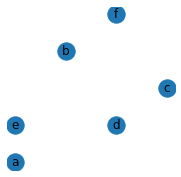

In [81]:
# City names and coordinates list[("name", (x, y))]
cities = [
    ("a", (0, 0)),
    ("b", (1, 3)),
    ("c", (3, 2)),
    ("d", (2, 1)),
    ("e", (0, 1)),
    ("f", (2,4))
]
plot_city(cities)

In [89]:
n_city = len(cities)
x = Array.create('H', (n_city, n_city), 'BINARY')

In [90]:
# Constraint not to visit more than two cities at the same time.
time_const = 0.0
for i in range(n_city):
    # If you wrap the hamiltonian by Const(...), this part is recognized as constraint
    time_const += Constraint((sum(x[i, j] for j in range(n_city)) - 1)**2, label="time{}".format(i))

# Constraint not to visit the same city more than twice.
city_const = 0.0
for j in range(n_city):
    city_const += Constraint((sum(x[i, j] for i in range(n_city)) - 1)**2, label="city{}".format(j))

In [91]:
# distance of route
distance = 0.0
for i in range(n_city):
    for j in range(n_city):
        for k in range(n_city):
            d_ij = dist(i, j, cities)
            distance += d_ij * x[k, i] * x[(k+1)%n_city, j]

In [92]:
# Construct hamiltonian
A = Placeholder("A")
H = distance + A * (time_const + city_const)

In [93]:
# Compile model
model = H.compile()

In [94]:
# Generate QUBO
feed_dict = {'A': 4.0}
bqm = model.to_bqm(feed_dict=feed_dict)

In [95]:
import neal
sa = neal.SimulatedAnnealingSampler()
sampleset = sa.sample(bqm, num_reads=100, num_sweeps=100)

print(sampleset)

   H[0][0] H[0][1] H[0][2] H[0][3] H[0][4] ... H[5][5]    energy num_oc.
74       0       1       0       0       0 ...       1 10.536631       1
7        0       0       0       0       0 ...       0 10.536631       1
34       0       0       0       0       0 ...       0 10.536631       1
3        0       0       0       0       1 ...       0 10.536631       1
32       0       0       0       0       1 ...       0 10.536631       1
47       0       0       0       0       1 ...       0 10.536631       1
91       0       1       0       0       0 ...       0 10.536631       1
20       1       0       0       0       0 ...       0 10.536631       1
25       1       0       0       0       0 ...       0 10.536631       1
13       0       0       1       0       0 ...       0 10.536631       1
30       1       0       0       0       0 ...       0 10.536631       1
71       0       1       0       0       0 ...       1 11.226773       1
67       0       0       1       0       0 ...     

In [ ]:
# Decode solution
decoded_samples = model.decode_sampleset(sampleset, feed_dict=feed_dict)
print(decoded_samples)

In [65]:
best_sample = min(decoded_samples, key=lambda x: x.energy)
print(best_sample)

In [ ]:
num_broken = len(best_sample.constraints(only_broken=True))
print("number of broken constarint = {}".format(num_broken))

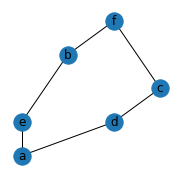

In [60]:
if num_broken == 0:
    plot_city(cities, best_sample)

## Lo hago con datos de excel

In [1]:
import pandas as pd
dat = pd.read_excel("D:\MisTrabajos\DWaveOcean\ejemplosJupyter\mios\datos1.xlsx", sheet_name='Hoja2')
dat2 = {}
for index, row in dat.iterrows():
    dat2[(row['init'],row['fin'])] = row['peso']

dat2

{(0, 0): 0,
 (0, 1): 1,
 (0, 2): 2,
 (0, 3): 3,
 (0, 4): 4,
 (0, 5): 5,
 (1, 0): 3,
 (1, 1): 0,
 (1, 2): 3,
 (1, 3): 4,
 (1, 4): 5,
 (1, 5): 7,
 (2, 0): 4,
 (2, 1): 2,
 (2, 2): 0,
 (2, 3): 2,
 (2, 4): 4,
 (2, 5): 6,
 (3, 0): 1,
 (3, 1): 2,
 (3, 2): 5,
 (3, 3): 0,
 (3, 4): 6,
 (3, 5): 8,
 (4, 0): 2,
 (4, 1): 5,
 (4, 2): 5,
 (4, 3): 2,
 (4, 4): 0,
 (4, 5): 3,
 (5, 5): 0,
 (5, 0): 3,
 (5, 1): 3,
 (5, 2): 7,
 (5, 3): 2,
 (5, 4): 3}

In [2]:
len(dat.init.unique())

6

In [3]:
def distancia(x, y, datos):
    return datos[x,y]

distancia(0,3,dat2)

3

In [134]:
#n_city = len(cities)
n_city = len(dat.init.unique())
x = Array.create('c', (n_city, n_city), 'BINARY')

In [135]:
# Constraint not to visit more than two cities at the same time.
time_const = 0.0
for i in range(n_city):
    # If you wrap the hamiltonian by Const(...), this part is recognized as constraint
    time_const += Constraint((sum(x[i, j] for j in range(n_city)) - 1)**2, label="time{}".format(i))

# Constraint not to visit the same city more than twice.
city_const = 0.0
for j in range(n_city):
    city_const += Constraint((sum(x[i, j] for i in range(n_city)) - 1)**2, label="city{}".format(j))

In [136]:
# distance of route
distance = 0.0
for i in range(n_city):
    for j in range(n_city):
        for k in range(n_city):
            d_ij = distancia(i, j, dat2)
            distance += d_ij * x[k, i] * x[(k+1)%n_city, j]

In [137]:
# Construct hamiltonian
A = Placeholder("A")
H = distance + A * (time_const + city_const)

In [138]:
# Compile model
model = H.compile()

In [139]:
# Generate QUBO
feed_dict = {'A': 5.0}
bqm = model.to_bqm(feed_dict=feed_dict)

In [140]:
import neal
sa = neal.SimulatedAnnealingSampler()
sampleset = sa.sample(bqm, num_reads=100, num_sweeps=100)

# Decode solution
decoded_samples = model.decode_sampleset(sampleset, feed_dict=feed_dict)
best_sample = min(decoded_samples, key=lambda x: x.energy)
num_broken = len(best_sample.constraints(only_broken=True))
print("number of broken constarint = {}".format(num_broken))

number of broken constarint = 0


In [141]:
print(sampleset.data)

<bound method SampleSet.data of SampleSet(rec.array([([0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0], 14., 1),
           ([0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0], 14., 1),
           ([0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0], 14., 1),
           ([0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0], 14., 1),
           ([0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1], 14., 1),
           ([0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1], 14., 1),
           ([0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1], 14., 1),
           ([0, 0, 1, 0, 0, 0, 0, 0, 0, 0

In [ ]:
df_train_join["num_prod_group"]=0
for index, row in df_train_join.iterrows():
    if row['number_active_produts"] <6 :
        df_train_join.loc[index,"num_prod_group"] = row['number_active_produts"]
    else:
        df_train_join.loc[index,"num_prod_group"] = 6